In [12]:
import pandas as pd
from plotnine import (
    ggplot, geom_point, geom_line, geom_smooth,
    aes, facet_wrap, labs,
    scale_x_log10, scale_y_continuous, scale_y_log10,
)
import patchworklib as pw
import numpy as np

from llm_ran.benchmark.metrics import pass_at, pass_power

In [13]:
DATA_PATH = "../data"
OUTPUT_PATH = "../../thesis/figures"
df = pd.read_csv(f"{DATA_PATH}/processed/combined.csv", index_col=0)
df = df[(df['scenario'] == "base") & (df['model'].str.startswith('qwen2.5:'))]
df['model_size'] = df['model'].str.split(':').str[1].str.replace('b', '').str.replace('8x', '').astype(float)
df = df.rename(columns={"chain": "agent"})
df.columns


Index(['scenario', 'question', 'trial', 'run_id', 'model', 'agent',
       'total_trials', 'level', 'evaluate_as', 'expected', 'num_messages',
       'execution_time', 'eval_count', 'prompt_eval_count', 'eval_duration',
       'prompt_eval_duration', 'load_duration', 'total_duration',
       'total_tokens', 'max_eval_count', 'max_prompt_eval_count',
       'max_eval_duration', 'max_prompt_eval_duration', 'max_load_duration',
       'max_total_duration', 'snapshot_path', 'result', 'error', 'file',
       'can_answer', 'correct', 'pass', 'deviation', 'model_size'],
      dtype='object')

In [14]:
group_by = ["model_size", "agent"]
metrics = ["can_answer", "correct", 'execution_time', "total_tokens", "num_messages", "pass"]
agg = {
    "can_answer@1": ('can_answer', pass_at(1)),
    "can_answer@5": ('can_answer', pass_at(5)),
    "can_answer^5": ('can_answer', pass_power(5)),
    "correct@1": ('correct', pass_at(1)),
    "correct@5": ('correct', pass_at(5)),
    "correct^5": ('correct', pass_power(5)),
    "pass@1": ('pass', pass_at(1)),
    "pass@5": ('pass', pass_at(5)),
    "pass^5": ('pass', pass_power(5)),
    "execution_time": ('execution_time', 'mean'),
    "total_tokens": ('total_tokens', 'mean'),
    "num_messages": ('num_messages', 'mean'),
}
resampled = df.groupby(group_by)[metrics].agg(**agg).reset_index()
# resampled = pd.concat(
#     df.groupby(group_by).sample(frac=0.5, random_state=i).groupby(group_by)[metrics].agg([])
#     for i in range(10)
# ).reset_index()
# resampled
display(resampled)
pivoted = resampled.melt(
    id_vars=group_by,
    value_vars=agg.keys(),
    var_name="metric",
    value_name="value",
)
# display(pivoted)

,model_size,agent,can_answer@1,can_answer@5,can_answer^5,correct@1,correct@5,correct^5,pass@1,pass@5,pass^5,execution_time,total_tokens,num_messages
0,0.5,codegen,0.087500,0.369905,0.000005,0.108333,0.439230,0.000015,0.029167,0.138664,2.110736e-08,0.855981,2474.979167,5.570833
1,0.5,direct,0.404167,0.927031,0.010785,0.125000,0.490176,0.000031,0.087500,0.369905,5.129089e-06,0.268292,2403.645833,3.954167
2,1.5,codegen,0.650000,0.995148,0.116029,0.133333,0.514221,0.000042,0.133333,0.514221,4.213992e-05,0.534427,436.254167,2.170833
3,1.5,direct,0.737500,0.998895,0.218178,0.112500,0.452332,0.000018,0.112500,0.452332,1.802032e-05,0.337752,1262.741667,2.237500
4,3.0,codegen,0.216667,0.708489,0.000477,0.133333,0.514221,0.000042,0.066667,0.293887,1.316872e-06,6.542573,7088.600000,11.408333
5,3.0,direct,0.758333,0.999280,0.250785,0.216667,0.708489,0.000477,0.208333,0.692474,3.924586e-04,0.871357,2456.900000,4.058333
6,7.0,codegen,0.483333,0.964616,0.026378,0.208333,0.692474,0.000392,0.179167,0.630793,1.846231e-04,4.812758,5106.333333,6.295833
7,7.0,direct,0.741667,0.998983,0.224411,0.337500,0.875100,0.004379,0.333333,0.871071,4.115226e-03,1.136162,2911.604167,4.854167
8,14.0,codegen,0.645833,0.994845,0.112358,0.500000,0.970049,0.031250,0.454167,0.953230,1.932308e-02,12.059471,6795.758333,9.466667
9,14.0,direct,0.825000,0.999866,0.382182,0.525000,0.976929,0.039884,0.445833,0.949489,1.761419e-02,2.199962,3273.562500,6.150000


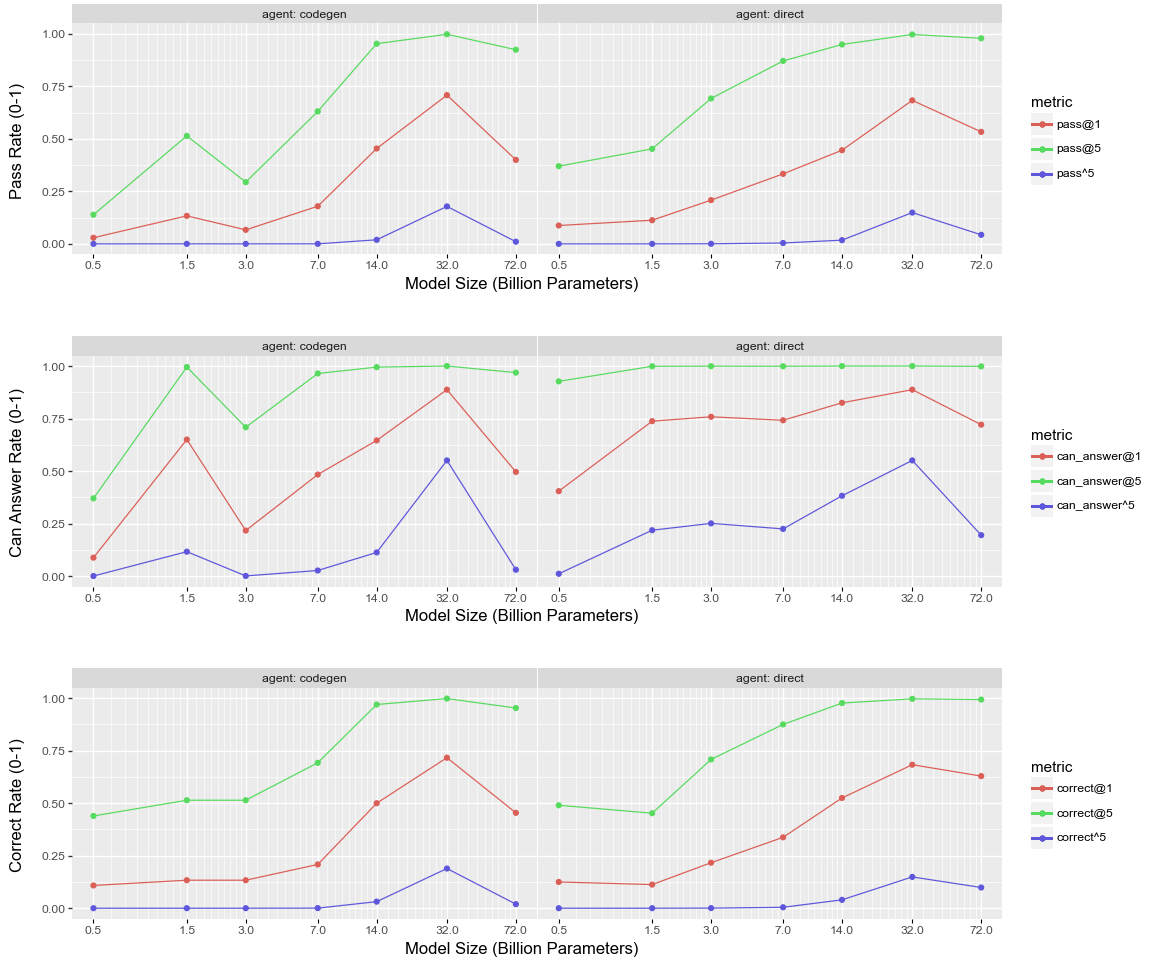

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [15]:
# Pass, can_answer, and correct rates
_g0 = (
    ggplot(pivoted[pivoted['metric'].str.startswith("pass")], aes(x='model_size', y="value", color="metric"))
    + geom_point()
    + geom_line()
    # + stat_smooth(method='lm')
    + scale_x_log10(
        breaks=resampled['model_size'].unique(),
        labels=resampled['model_size'].unique(),
    )
    + scale_y_continuous(limits=(0, 1))
    + facet_wrap('agent', labeller="label_both")
    + labs(
        x='Model Size (Billion Parameters)',
        y='Pass Rate (0-1)',
        # title='Pass Rate vs Model Size',
    )
)
_g1 = (
    ggplot(pivoted[pivoted['metric'].str.startswith("can_answer")], aes(x='model_size', y="value", color="metric"))
    + geom_point()
    + geom_line()
    # + stat_smooth(method='lm')
    + scale_x_log10(
        breaks=resampled['model_size'].unique(),
        labels=resampled['model_size'].unique(),
    )
    + scale_y_continuous(limits=(0, 1))
    + facet_wrap('agent', labeller="label_both")
    + labs(
        x='Model Size (Billion Parameters)',
        y='Can Answer Rate (0-1)',
        # title='Can-answer Rate vs Model Size',
    )
)
_g2 = (
    ggplot(pivoted[pivoted['metric'].str.startswith("correct")], aes(x='model_size', y="value", color="metric"))
    + geom_point()
    + geom_line()
    # + stat_smooth(method='lm')
    + scale_x_log10(
        breaks=resampled['model_size'].unique(),
        labels=resampled['model_size'].unique(),
    )
    + scale_y_continuous(limits=(0, 1))
    + facet_wrap('agent', labeller="label_both")
    + labs(
        x='Model Size (Billion Parameters)',
        y='Correct Rate (0-1)',
        # title='Correct Rate vs Model Size',
    )
)
_figsize = (12, 3)
_g = (
    pw.load_ggplot(_g0, _figsize)
    / pw.load_ggplot(_g1, _figsize)
    / pw.load_ggplot(_g2, _figsize)
)
# _g.set_suptitle("Scaling Performance of Qwen-2.5 Models")
_g.savefig(f"{OUTPUT_PATH}/scaling_performance.png", bbox_inches='tight')

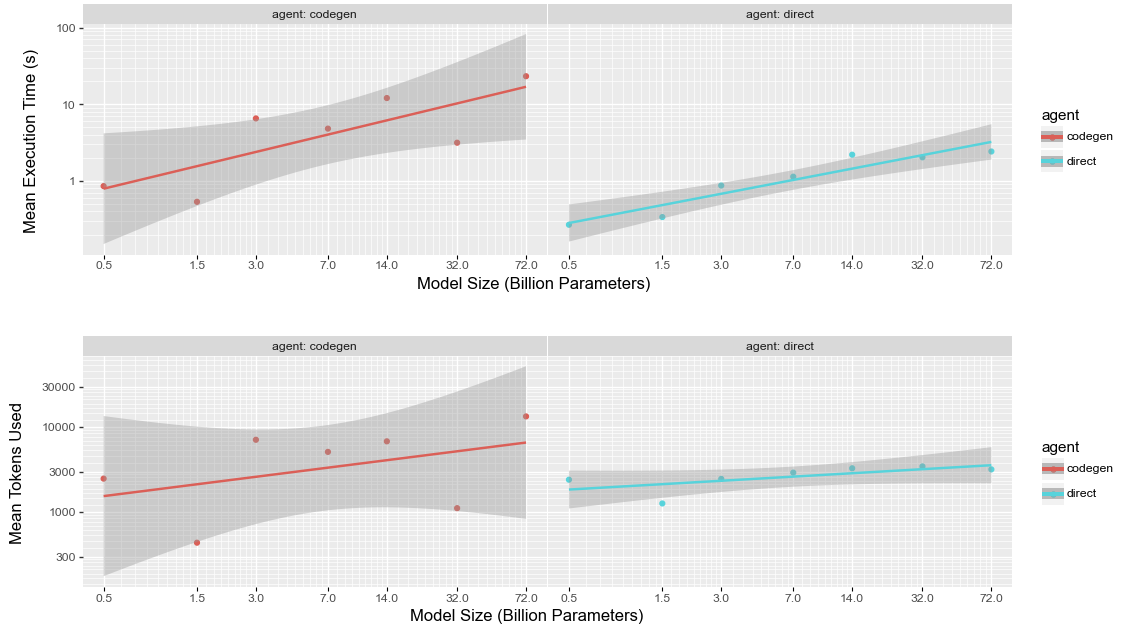

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [16]:
# Model size vs. execution time
_g1 = (
    ggplot(resampled, aes(x='model_size', y="execution_time", color="agent"))
    + geom_point()
    + geom_smooth(method='lm')
    + scale_x_log10(
        breaks=resampled['model_size'].unique(),
        labels=resampled['model_size'].unique(),
    )
    + scale_y_log10()
    + facet_wrap('agent', labeller="label_both")
    + labs(
        x='Model Size (Billion Parameters)',
        y='Mean Execution Time (s)',
        # title='Execution Time vs Model Size',
    )
)
_g2 = (
    ggplot(resampled, aes(x='model_size', y="total_tokens", color="agent"))
    + geom_point()
    + geom_smooth(method='lm')
    + scale_x_log10(
        breaks=resampled['model_size'].unique(),
        labels=resampled['model_size'].unique(),
    )
    + scale_y_log10()
    + facet_wrap('agent', labeller="label_both")
    + labs(
        x='Model Size (Billion Parameters)',
        y='Mean Tokens Used',
        # title='Tokens Used vs Model Size',
    )
)
_figsize = (12, 3)
_g = pw.load_ggplot(_g1, _figsize) / pw.load_ggplot(_g2, _figsize)
# _g.set_suptitle("Scaling Cost of Qwen-2.5 Models")
_g.savefig(f"{OUTPUT_PATH}/scaling_cost.png", bbox_inches='tight')